# Randomized Hyperparameter Search in Tensorflow

Even a vanilla convolutional neural network has many hyperparamters, including those that define the overall architecture, choice of activation functions and learning rate. A standard grid search would require a huge amount of processing, given that a single network can take long time to train. An alternative is a randomized hyperparameter search.

Below, Tensorflow is used to build a CNN to classify the images in the CIFAR-10 dataset.

The optimal architecture, learning rate and other hyperparameters of the CNN are searched for using a randomized method.

The CIFAR-10 comes from: [Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

## Data Preparation

In [1]:
# Provided on https://www.cs.toronto.edu/~kriz/cifar.html 
# Given a "pickled" file, returns a dictionary containing the image data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

The training data is stored in four files, which are read and merged.

In [2]:
import numpy as np

for file_no in range(4):
    # Obtain data dictionary from each file
    filename = "cifar-10-batches-py/data_batch_" + str(file_no + 1)
    image_batch = unpickle(filename)
    # First file, create numpy arrays containing data & labels
    if file_no == 0:
        # Reshape to 32x32 image with 3 channels (RGB), which is made to be the last axes
        image_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_labels = image_batch[b'labels']
    else: # Concatenate to one file
        new_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_data = np.concatenate([image_data, new_data])
        image_labels = np.concatenate([image_labels, image_batch[b'labels']])

print("Training data shape: ",image_data.shape)

# Create numpy array containing test data
test_batch = unpickle("cifar-10-batches-py/test_batch")
test_data = test_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
test_labels = test_batch[b'labels']

# Obtain label names from the meta data
label_names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']
label_names = [l.decode('UTF-8') for l in label_names]

Training data shape:  (40000, 32, 32, 3)


### Image samples

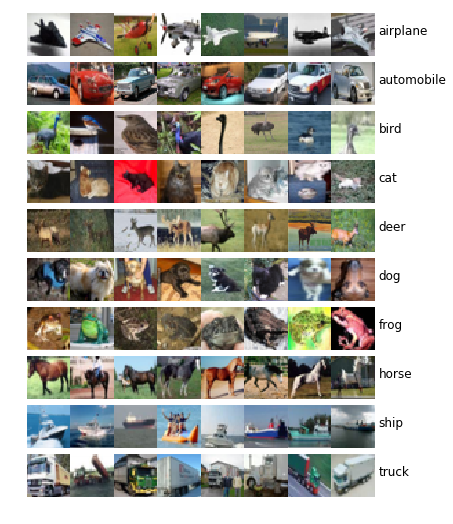

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10,9,figsize=(7,9))
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for image_type in range(10):
    # Obtain indices of images in each group
    group = np.argwhere(image_labels == image_type)
    # Display 1st 5 images from each group
    for col in range(8):
        n = group[col][0]
        img_rgb = image_data[n]
        axes[image_type,col].imshow(img_rgb)
        axes[image_type,col].axis('off')
    # Display image labels    
    axes[image_type,8].axis('off')    
    axes[image_type,8].text(0.1,0.5,label_names[image_type], fontsize=12)

plt.show()

## Model Building

In [4]:
import tensorflow as tf
# Fixed hyperparameters
height = 32
width = 32
channels = 3
outputs = 10

n_epochs = 500
# number of epochs to try to get a lower loss before stopping
early_stop_rounds = 10

# number of iterations, within epoch, to do an accuracy check
acc_check = 25

# Variable Hyperparameters
hyperparam_range = {'filters1':[16, 32, 64, 96],
                    'ksize1':[3, 4, 5],
                    'filters2':[48, 64, 96, 128],
                    'ksize2':[3, 4, 5],
                    'filters3':[64, 96, 128],
                    'ksize3':[3, 4, 5],
                    'full_hidd1':[60, 100, 125],
                    'full_hidd2':[80, 100, 125],
                    'activation':['relu', 'lrelu', 'elu'],
                    'learning_rate':[0.001, 0.0015, 0.002, 0.003],
                    'batch_size':[32, 64, 128, 256],
                    'momentum':[0.9, 0.95, 0.99],
                    'patch_reduction':[0,1,2],
                    'optimizer':['adam', 'rmsprop', 'nesterov']
                   }

# Calculate the number of hyperparamter grid points
first_item = True
for key,values in hyperparam_range.items():
    count = len(values)
    if first_item:
        display = str(count)
        total = count
        first_item = False
    else:
        display = display + ' X ' + str(count)
        total *= count

print('The total number of possible hyperparameter combinations is ' + display + ' = ' + "{:,}".format(total))

The total number of possible hyperparameter combinations is 3 X 4 X 3 X 3 X 4 X 3 X 4 X 3 X 3 X 3 X 3 X 3 X 3 X 4 = 15,116,544


In [5]:
def conv_layer(tensor_input, layer_no, filters, ksize, kstride, activation_unit, momentum, phase_train):
    # convolutional layer with batch normalisation and max pooling
    with tf.name_scope("conv_layer" + str(layer_no)):
        conv = tf.layers.conv2d(
            tensor_input,
            filters=filters,
            kernel_size=ksize,
            strides=[kstride,kstride],
            padding="SAME",
            activation=None
        )

        conv_bn = tf.layers.batch_normalization(
            inputs=conv,
            axis=-1,
            momentum=0.9,
            epsilon=0.001,
            center=True,
            scale=True,
            trainable=True,
            training = phase_train
        )

        #apply activation unit
        conv_bn_relu =  activation_unit(conv_bn)

        max_pool = tf.nn.max_pool(
            conv_bn_relu,
            ksize=[1,2,2,1],
            strides=[1,2,2,1],
            padding="VALID"
        )
            
        return max_pool

In [6]:
def build_graph(hyperparam):
    # Retrieve hyperparamaters from dictionary   
    filters1 = hyperparam['filters1']
    ksize1 = hyperparam['ksize1']
    filters2 = hyperparam['filters2']
    ksize2 = hyperparam['ksize2']
    filters3 = hyperparam['filters3']
    ksize3 = hyperparam['ksize3']
    full_hidd1 = hyperparam['full_hidd1']
    full_hidd2 = hyperparam['full_hidd2']
    activation = hyperparam['activation']
    learning_rate = hyperparam['learning_rate']
    momentum = hyperparam['momentum']
    patch_reduction =  hyperparam['patch_reduction']
    optimizer_method = hyperparam['optimizer']
    
    patch_height = height - 2 * patch_reduction
    patch_width = width - 2 * patch_reduction
    
    if activation == 'elu':
        activation_unit = tf.nn.elu
    elif activation == 'lrelu':
        activation_unit = tf.nn.leaky_relu
    else:    
        activation_unit = tf.nn.relu
        
    graph = tf.Graph()
    with graph.as_default():
        X = tf.placeholder(shape=(None, patch_height, patch_width, channels), dtype=tf.float32)
        y = tf.placeholder(shape=(None), dtype=tf.int32)
        phase_train = tf.placeholder(tf.bool, name='phase_train')

        # 1st convolutional layer
        conv1 = conv_layer(X, 1, filters1, ksize1, 2, activation_unit, momentum, phase_train)
        
        # 2nd convolutional layer
        conv2 = conv_layer(conv1, 2, filters2, ksize2, 1, activation_unit, momentum, phase_train)
        
        # 3rd cnn
        conv3 = conv_layer(conv2, 3, filters3, ksize3, 1, activation_unit, momentum, phase_train)
        
        # 1st fully connected (dense) layer
        fully_conn1 = tf.layers.dense(conv3, full_hidd1, name="fully_conn1", activation=activation_unit)
        flat = tf.contrib.layers.flatten(fully_conn1)
        
        # 2nd fully connected layer
        fully_conn2 = tf.layers.dense(flat, full_hidd2, name="fully_conn2", activation=activation_unit)
        
        # Output layer (no activation function, as this is built into cross-entropy)
        logits = tf.layers.dense(fully_conn2, outputs, name="logits")

        # Cross Entropy Loss
        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name="loss")

        # Training    
        with tf.name_scope("train"):
            if optimizer_method == 'rmsprop':
                    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9)
            elif optimizer_method == 'nesterov':
                    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov = True)
            else:    
                optimizer = tf.train.AdamOptimizer(learning_rate)
            training_op = optimizer.minimize(loss)
    
        # Initialization & Saver
        init = tf.global_variables_initializer()
        saver = tf.train.Saver() 
        
        return graph, X, y, phase_train, logits, loss, training_op, init, saver


### Model Training

In [7]:
# Function to train model, returns minimised loss
def train_model(batch_size = 128):
    training_size = image_data.shape[0]
    no_batches = training_size // batch_size

    
    with graph.as_default():
        # Ensure batch normalisation gets updated
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
        # Add Evaluation metrics
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            acc_summary = tf.summary.scalar('Accuracy', accuracy)
            loss_summary = tf.summary.scalar('Loss', loss)
            train_summary = tf.Summary()
            
            
    
    # Initialise best loss for early stopping
    best_loss = 1e9
    best_acc = 1e9
    early_stopping = False
    
    # Run training
    with tf.Session(graph=graph) as sess:                     
        init.run()
        epoch = 0
        early_stop_count = 0
        # Initialise training accuracy sum
        sum_acc_train = 0.0
        sum_loss_train = 0.0
        count_train = 0
        while (epoch < n_epochs) and (not early_stopping):
            epoch += 1
            # Shuffle training data
            p = np.random.permutation(training_size)
            image_data_shuffle = image_data_patch[p]
            image_labels_shuffle = image_labels[p]
            for iteration in range(no_batches-1):
                # Train on mini-batch
                X_batch = image_data_shuffle[iteration * batch_size:(iteration + 1) * batch_size + 1]
                y_batch = image_labels_shuffle[iteration * batch_size:(iteration + 1) * batch_size + 1]
                sess.run([training_op, extra_update_ops], feed_dict={X: X_batch, y: y_batch, phase_train: True})
                # Evaluate model on current mini-batch
                if (iteration % acc_check == 0):
                    acc_train, loss_train = sess.run([accuracy, loss], feed_dict={X: X_batch,
                                                                                   y: y_batch,
                                                                                   phase_train: True})
                    # Update training average for current epoch
                    sum_acc_train += acc_train
                    sum_loss_train += loss_train
                    count_train += 1
                    mean_acc_train = sum_acc_train / count_train
                    mean_loss_train = sum_loss_train / count_train
                    print(epoch, iteration, "Train accuracy:", mean_acc_train, " Train loss:", mean_loss_train, end='\r')
                     
            # Print mean Train accuracy        
            print(epoch, iteration, "Train accuracy:", mean_acc_train, " Train loss:", mean_loss_train)
            train_summary.value.add(tag='eval/Accuracy', simple_value=mean_acc_train)
            train_summary.value.add(tag='eval/Loss', simple_value=mean_loss_train)
            file_writer_train.add_summary(train_summary, epoch)
            
            # Evaluate model on test data every epoch
            acc_test, loss_test, summary_str_acc_test, summary_str_loss_test = sess.run([accuracy, loss,
                                                                                         acc_summary,
                                                                                         loss_summary],
                                                                                        feed_dict={X: test_data_patch,
                                                                                                   y: test_labels,
                                                                                                   phase_train: False})
            # Check for mininimum loss
            if loss_test < best_loss:
                # Reset early stopping best loss and count
                best_loss = loss_test
                best_acc = acc_test
                best_train_acc = mean_acc_train
                best_train_loss = mean_loss_train
                early_stop_count = 0
                # Save model
                save_path = saver.save(sess, ckptfile)
            else:
                # Increment early stopping count
                early_stop_count += 1
            # Check if sufficient rounds (epochs) have passed without improvement
            if early_stop_count  > early_stop_rounds:
                # Flag early stopping, so training loop will stop
                early_stopping = True
                print("Early stopping, best loss: ", best_loss)
            else:    
                # Record and display test loss and accuracy
                file_writer_test.add_summary(summary_str_acc_test, epoch)
                file_writer_test.add_summary(summary_str_loss_test, epoch)
                print(epoch, "Test accuracy:", acc_test, " Test loss:", loss_test)
            
        # Return Best Loss obtaned and number of epochs
        return best_loss, best_acc, best_train_acc, best_train_loss, epoch

In [ ]:
import pandas as pd

import random
random.seed(12344)

import os.path
if not os.path.exists('./log'):
    os.makedirs('./log')
if not os.path.exists('./graphs'):
    os.makedirs('./graphs')
    
if(os.path.isfile('./log/model_hyperparam.csv')):
    hyperparam_df = pd.read_csv('./log/model_hyperparam.csv')
    new_results_file = False
else:
    new_results_file = True

# Random Model search
for n in range(50):
    # Create log directory using current timestamp
    from datetime import datetime
    now = datetime.now().strftime("%Y%m%dT%H%M%S")
    root_logdir = "./log"
    root_graphdir = "./graphs"
    logdir = "{}/run-{}/".format(root_logdir, now)
    graphdir = "{}/run-{}/".format(root_graphdir, now)
    #root_modeldir = "./model"
    graphfile = graphdir
    ckptfile = graphdir + "checkpoint.ckpt"

    # Note that the graph is not written using same filewriter as the logging data.
    # This allows the logs to be viewed during training before the filewriter is closed
    file_writer_train = tf.summary.FileWriter(logdir + '/train')
    file_writer_test = tf.summary.FileWriter(logdir + '/test')
    
    # tensorboard --logdir e:\Programming\TensorFlow\CIFAR-10\log
    # The command must be executed from same drive (E:) as the logdir

    tf.reset_default_graph()

    hyperparam_dict = {key:random.choice(values) for (key,values) in hyperparam_range.items()}
    print("Training Model with following hyperparameters:")
    print(hyperparam_dict)

    # Obtain graph and nodes required for training
    graph, X, y, phase_train, logits, loss, training_op, init, saver = build_graph(hyperparam = hyperparam_dict)
    
    # Write graph to file and close to avoid TensorBoard conflict
    file_writer_graph = tf.summary.FileWriter(graphfile, graph)
    file_writer_graph.close()

    # Extract image patches
    patch_reduction =  hyperparam_dict['patch_reduction']
    if patch_reduction == 0:
        image_data_patch = image_data
        test_data_patch = test_data
    else:
        image_data_patch = image_data[:,patch_reduction:-patch_reduction,patch_reduction:-patch_reduction,:]
        test_data_patch = test_data[:,patch_reduction:-patch_reduction,patch_reduction:-patch_reduction,:]
    
    # Train the model
    best_loss, best_acc, best_train_acc, best_train_loss, no_epochs = train_model(batch_size = hyperparam_dict['batch_size'])
    
    # Add results to dictionary
    hyperparam_dict['best_loss'] = best_loss
    hyperparam_dict['best_acc'] = best_acc
    hyperparam_dict['best_train_acc'] = best_train_acc
    hyperparam_dict['best_train_loss'] = best_train_loss
    hyperparam_dict['no_epochs'] = no_epochs
    hyperparam_dict['logdir'] = logdir
    
    # Add results to dataframe
    if new_results_file:
        hyperparam_df = pd.DataFrame(hyperparam_dict, index=[0])
        new_results_file = False
    else:
        hyperparam_df = hyperparam_df.append(hyperparam_dict, ignore_index=True)
        
    # Write results file (don't wait until end, as next model may be interrupted)
    hyperparam_df.to_csv('./log/model_hyperparam_2.csv', index=False)

    # Close filewriters
    file_writer_train.close()
    file_writer_test.close()

Training Model with following hyperparameters:
{'full_hidd1': 60, 'full_hidd2': 125, 'optimizer': 'adam', 'batch_size': 256, 'learning_rate': 0.002, 'ksize1': 4, 'filters1': 64, 'activation': 'relu', 'ksize3': 5, 'ksize2': 3, 'filters3': 64, 'patch_reduction': 1, 'momentum': 0.95, 'filters2': 96}
1 154 Train accuracy: 0.464702595557  Train loss: 1.46307192537
1 Test accuracy: 0.5188  Test loss: 1.30803


## Results

In [ ]:
hyperparam_df = pd.read_csv('./log/model_hyperparam_2.csv')
hyperparam_df.sort_values(by = ['best_loss'])

## Conclusion
Learning rates of 0.01 and 0.03 are clearly not converging. So these will be eliminated from further searches.

Accuracy is only reaching 60% at the moment. Training accuracy (see training output) was not much higher, which suggests overfitting is not the problem.

Architectures with more features in the convolutional layers and more nodes in the fully connected layers tend to perform better. So it worth considering a deeper network with more features/nodes.

Alternative activation functions and optimisation algorithms will also be included in future searches. Regularization will also be considered.

In [23]:
print(graphfile)

./log/run-20180127T185646//graph
